In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
import os

Using TensorFlow backend.


(224, 224, 3)


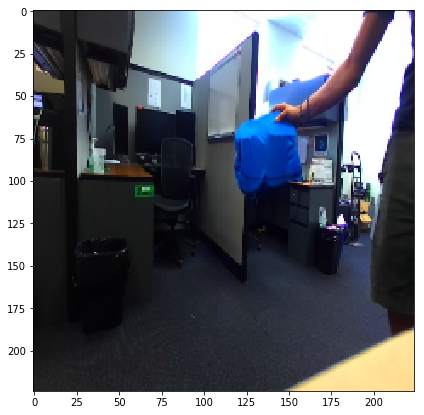

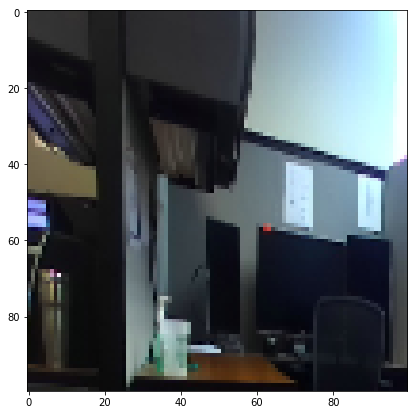

In [57]:
DATA = lambda p: os.path.join('../datafiles', p)

def myimread(fname):
    import skimage.io, skimage.transform
    im = skimage.transform.resize(skimage.io.imread(fname), (224, 224))
    return im[...,::-1]*255

def myimshow(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im[...,::-1]/255)
    
def myimshow_grey(im):
    plt.figure(figsize=(7,7))
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

test_im = myimread(DATA('zed-subset/556-left.jpeg'))
print(test_im.shape)

myimshow(test_im)
myimshow(test_im[:100,:100,:])

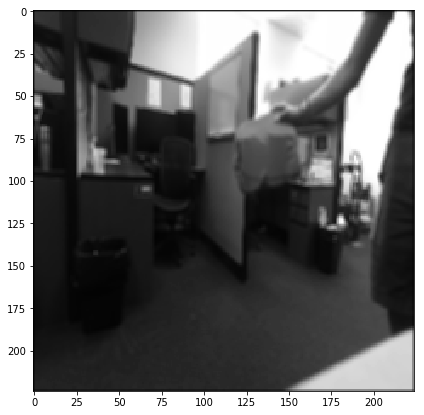

In [76]:
def fmean_c2g(input_im):
    model = Sequential()
    model.add(Convolution2D(1, 3, 3, activation='relu', input_shape=(3,224,224), weights=(
        np.ones((1,3,3,3))*(1./9/3), # weights: (#filters, #channels, #rows, #cols)
        np.zeros(1) # biases: (#filters, )
    ), border_mode='same'))
    
    def mypreprocess(i):
        out = i.copy()
    #     out[:] -= np.array([103.939, 116.779, 123.68])
        return np.expand_dims(out.transpose((2,0,1)), axis=0)

    def mypostprocess(i):
        return i[0][0]
    
    output_im = mypostprocess(model.predict(mypreprocess(input_im)))
#     print(input_im.shape, output_im.shape)
    return output_im

myimshow_grey(fmean_c2g(test_im))

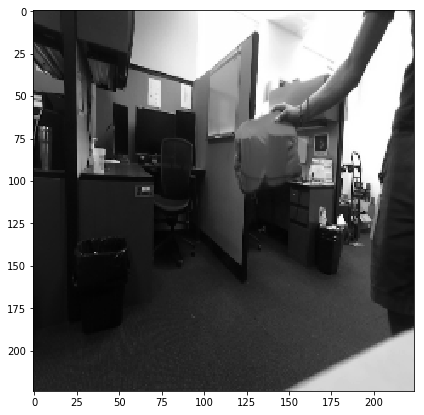

In [77]:
def color2grey(input_im):
    model = Sequential()
    model.add(Convolution2D(1, 1, 1, activation='relu', input_shape=(3,224,224), weights=(
        np.ones((1,3,1,1))*(1./3), # weights: (#filters, #channels, #rows, #cols)
        np.zeros(1) # biases: (#filters, )
    ), border_mode='same'))
    
    def mypreprocess(i):
        out = i.copy()
    #     out[:] -= np.array([103.939, 116.779, 123.68])
        return np.expand_dims(out.transpose((2,0,1)), axis=0)

    def mypostprocess(i):
        return i[0][0]
    
    output_im = mypostprocess(model.predict(mypreprocess(input_im)))
#     print(input_im.shape, output_im.shape)
    return output_im

myimshow_grey(color2grey(test_im))

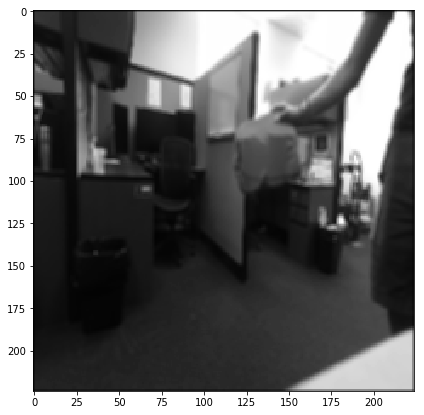

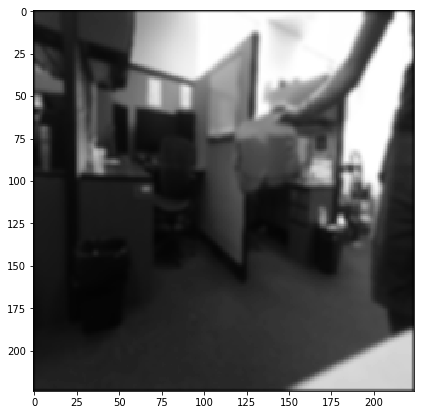

In [89]:
def fmean(input_im):
    model = Sequential()
    model.add(Convolution2D(1, 3, 3, activation='relu', input_shape=(1,224,224), weights=(
        np.ones((1,1,3,3))*(1./9), # weights: (#filters, #channels, #rows, #cols)
        np.zeros(1) # biases: (#filters, )
    ), border_mode='same'))
    
    def mypreprocess(i):
        out = i.copy()
        return np.expand_dims(out[np.newaxis,...], axis=0)

    def mypostprocess(i):
        return i[0][0]
    
    output_im = mypostprocess(model.predict(mypreprocess(input_im)))
#     print(input_im.shape, output_im.shape)
    return output_im

myimshow_grey(fmean(color2grey(test_im)))
myimshow_grey(fmean(fmean(color2grey(test_im)))) # more blury


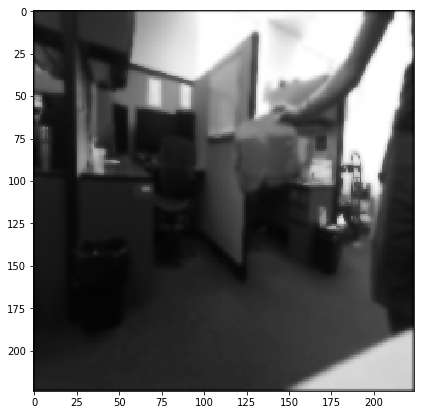

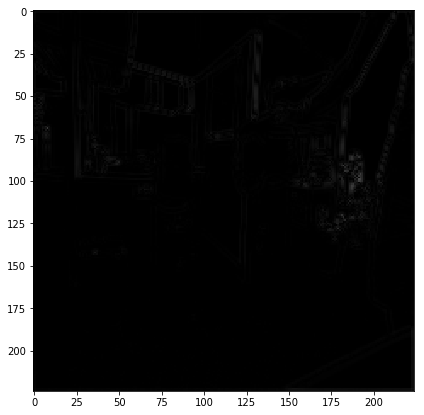

In [98]:
def guidedFilter(im, guidance, radius = 3, regularization = 0.16):
    p = color2grey(im)/255
    I = color2grey(guidance)/255
    mean_p, mean_I = fmean(p), fmean(I)
    corr_I, corrIp = fmean(I*I), fmean(I*p)
    var = corr_I - mean_I*mean_I
    cov = corrIp - mean_I*mean_p
    a = cov / (var + regularization)
    b = mean_p - a*mean_I
    return (fmean(a)*I+fmean(b))*255

greyimg = color2grey(test_im)
filtered = guidedFilter(test_im, test_im)
# myimshow_grey(greyimg)
myimshow_grey(filtered)
# myimshow_grey(abs(greyimg-filtered))
myimshow_grey(abs(fmean(greyimg)-filtered))